In [1]:
from pandas import read_excel
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

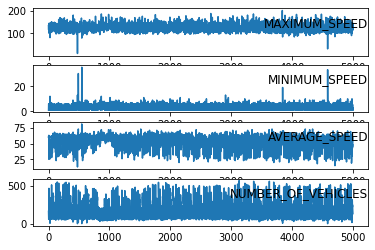

In [12]:
# load dataset
dataset = read_excel(r'C:\sxk990_2_6ay.xlsx', header=0, index_col=0)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

In [13]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
                agg.dropna(inplace=True)
        return agg


In [14]:
# specify the number of lag hours
n_hours = 4
n_steps = 1
n_features = 1
n_obs = n_hours * n_features
n_x = (n_hours * n_features) - n_steps
# frame as supervised learning
reframed = series_to_supervised(values, n_hours, n_steps)
# drop columns we don't want to predict

for i in range (0,n_steps):
   reframed.drop(reframed.columns[[n_obs+i,n_obs+i+1,n_obs+i+3]], axis=1, inplace=True) 

reframed

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
4,119.0,1.0,60.0,162.0,62.0,132.0,6.0,62.0,68.0,121.0,6.0,60.0,59.0,128.0,5.0,56.0,88.0
5,137.0,6.0,62.0,123.0,62.0,121.0,6.0,60.0,59.0,128.0,5.0,56.0,88.0,140.0,6.0,63.0,190.0
6,132.0,6.0,62.0,68.0,60.0,128.0,5.0,56.0,88.0,140.0,6.0,63.0,190.0,144.0,1.0,52.0,463.0
7,121.0,6.0,60.0,59.0,56.0,140.0,6.0,63.0,190.0,144.0,1.0,52.0,463.0,120.0,2.0,25.0,327.0
8,128.0,5.0,56.0,88.0,63.0,144.0,1.0,52.0,463.0,120.0,2.0,25.0,327.0,120.0,3.0,28.0,226.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,121.0,1.0,49.0,217.0,49.0,124.0,2.0,44.0,235.0,113.0,1.0,46.0,224.0,122.0,1.0,47.0,198.0
4994,116.0,1.0,49.0,248.0,44.0,113.0,1.0,46.0,224.0,122.0,1.0,47.0,198.0,128.0,3.0,53.0,168.0
4995,124.0,2.0,44.0,235.0,46.0,122.0,1.0,47.0,198.0,128.0,3.0,53.0,168.0,145.0,1.0,51.0,187.0
4996,113.0,1.0,46.0,224.0,47.0,128.0,3.0,53.0,168.0,145.0,1.0,51.0,187.0,139.0,2.0,55.0,134.0


In [5]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [6]:
# split into train and test sets
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train = reframed[:int(len(reframed)*TRAIN_SIZE), :]
test = reframed[int(len(reframed)*TRAIN_SIZE):, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_steps:]
test_X, test_y = test[:, :n_obs], test[:, -n_steps:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, len(test_X))

(2160, 4, 4) (2160, 1) (2834, 4, 4) (2834, 1) 2834


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, RepeatVector,TimeDistributed
from keras.layers import LSTM, Bidirectional, GRU
from keras.layers.recurrent import LSTM
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from matplotlib import pyplot

In [8]:

model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(RepeatVector(train_y.shape[1]))
#model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(n_steps)))
model.compile(loss='mae', optimizer='adam')
model.fit(train_X, train_y, epochs = 1000, batch_size = 32, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    

In [9]:
# make a prediction
pred_train_y = model.predict(train_X).reshape((len(train_y), n_steps))
train_X = train_X.reshape((train_X.shape[0], n_obs))
pred_train_y.shape

(2160, 1)

In [10]:
# invert scaling for forecast
pred_train_y = concatenate((train_X[:, -n_obs:], pred_train_y), axis=1)
pred_train_y = scaler.inverse_transform(pred_train_y)
pred_train_y = pred_train_y[:,-n_steps:]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), n_steps))
train_y = concatenate((train_X[:, -n_obs:], train_y), axis=1)
train_y = scaler.inverse_transform(train_y)
train_y = train_y[:,-n_steps:]

In [11]:
# make a prediction
pred_test_y = model.predict(test_X).reshape((len(test_y), n_steps))
test_X = test_X.reshape((test_X.shape[0], n_obs))

# invert scaling for forecast
pred_test_y = concatenate(( test_X[:, -n_obs:], pred_test_y), axis=1)
pred_test_y = scaler.inverse_transform(pred_test_y)
pred_test_y = pred_test_y[:,-n_steps:]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), n_steps))
test_y = concatenate((test_X[:, -n_obs:], test_y), axis=1)
test_y = scaler.inverse_transform(test_y)
test_y = test_y[:,-n_steps:]

In [12]:
# calculate RMSE
rmse_train = sqrt(mean_squared_error(train_y, pred_train_y))
print("Train data score: %.2f RMSE" % rmse_train)

rmse_test = sqrt(mean_squared_error(test_y, pred_test_y))
print("Test data score: %.2f RMSE" % rmse_test)

Train data score: 1.72 RMSE
Test data score: 7.57 RMSE


In [13]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(train_y, pred_train_y)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(test_y, pred_test_y)
print("Test data score: %.2f MAPE" % error_mape_t)

Train data score: 2.41 MAPE
Test data score: 13.33 MAPE


In [14]:
mdape_tr = np.median((np.abs(np.subtract(train_y, pred_train_y)/ train_y))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(test_y, pred_test_y)/ test_y))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 1.61 MdAPE
Test data score: 8.34 MdAPE


In [15]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(train_y, pred_train_y)
print("Train data score: %.2f SMAPE" % error_smape_tr)

error_smape_t = smape(test_y, pred_test_y)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 2.39 SMAPE
Test data score: 12.20 SMAPE


In [16]:
from sklearn.metrics import mean_absolute_error
e_tr = train_y - pred_train_y
scale = mean_absolute_error(train_y[1:], train_y[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = test_y - pred_test_y
scale = mean_absolute_error(test_y[1:], test_y[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

Train data score: 0.24 MASE
Test data score: 1.00 MASE


IndexError: index 1 is out of bounds for axis 1 with size 1

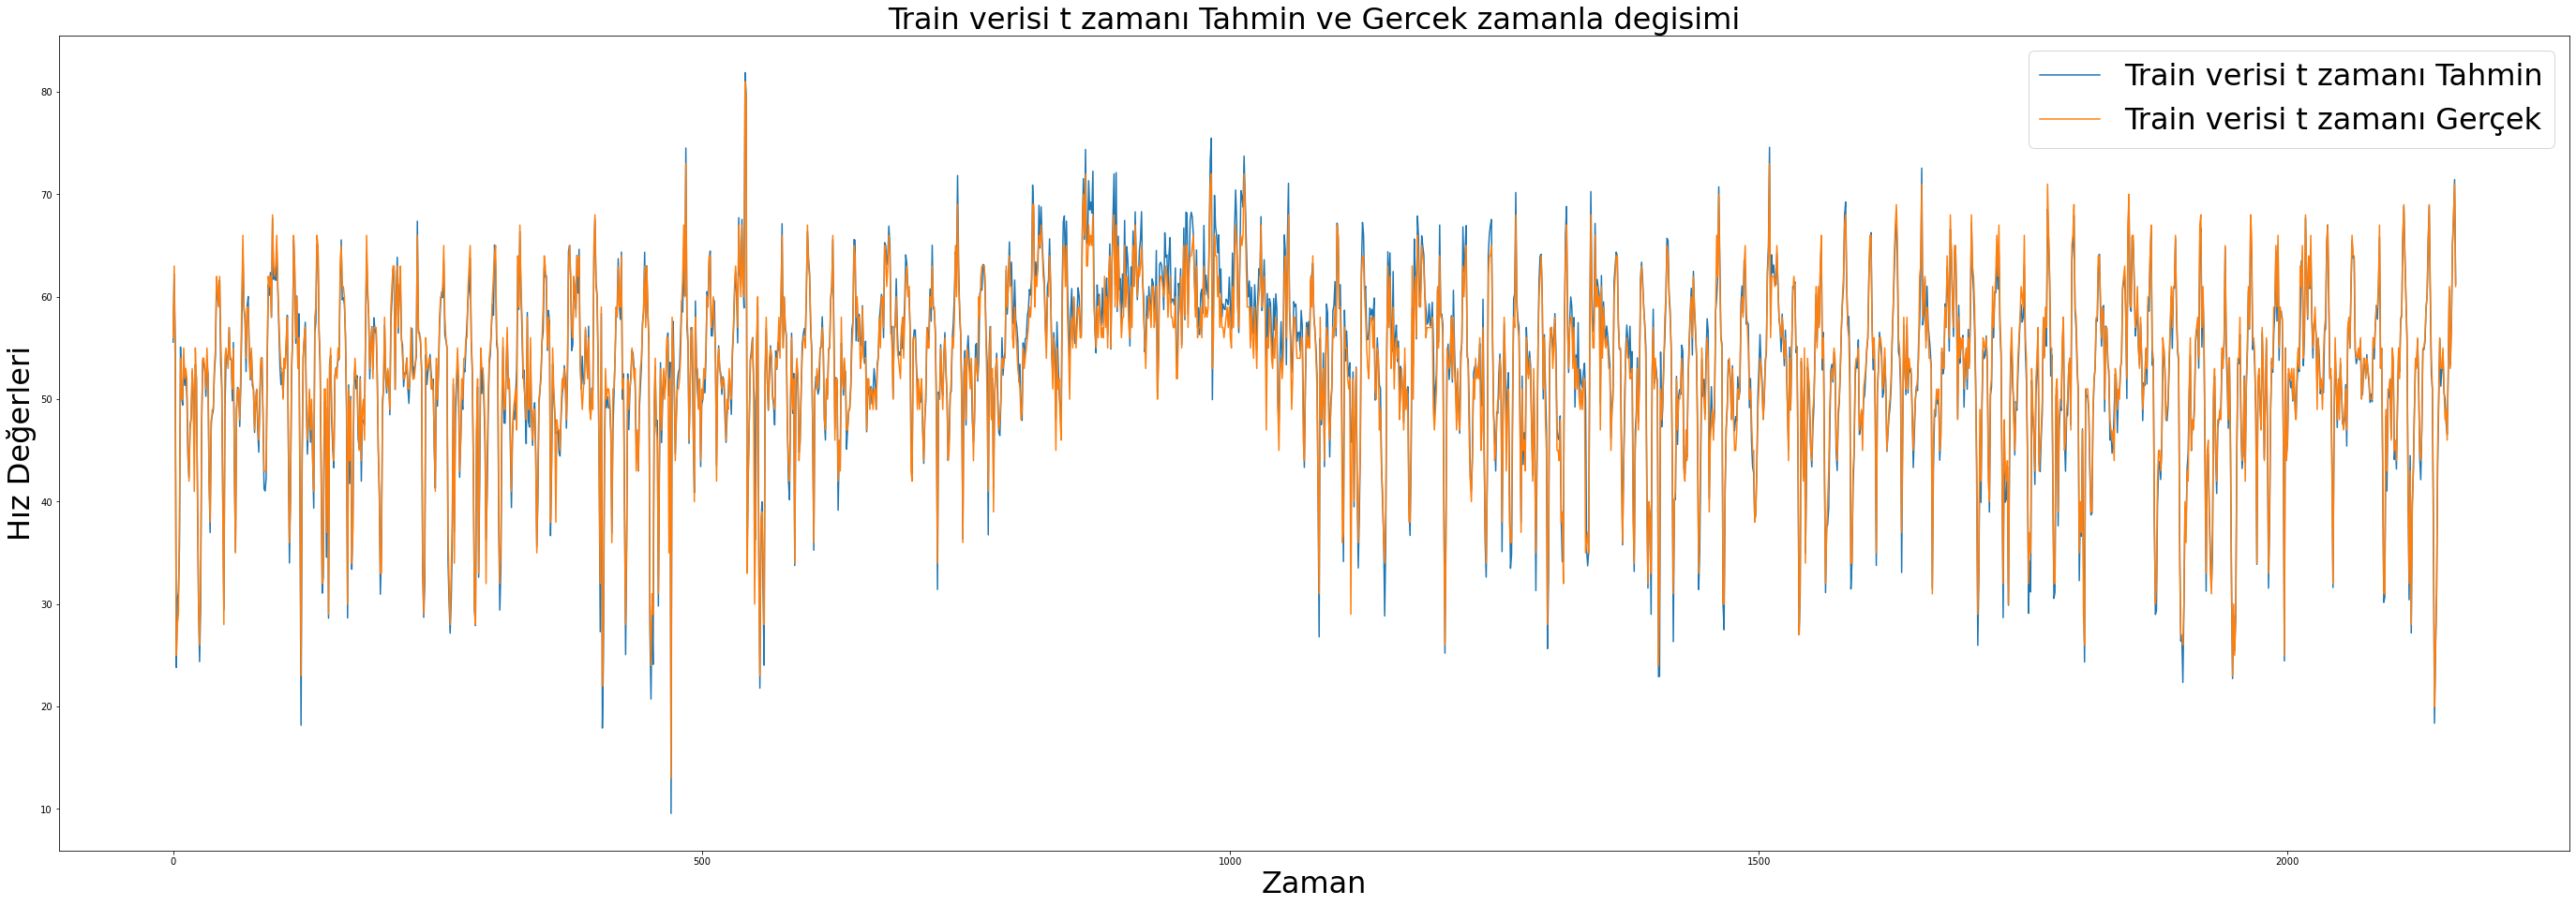

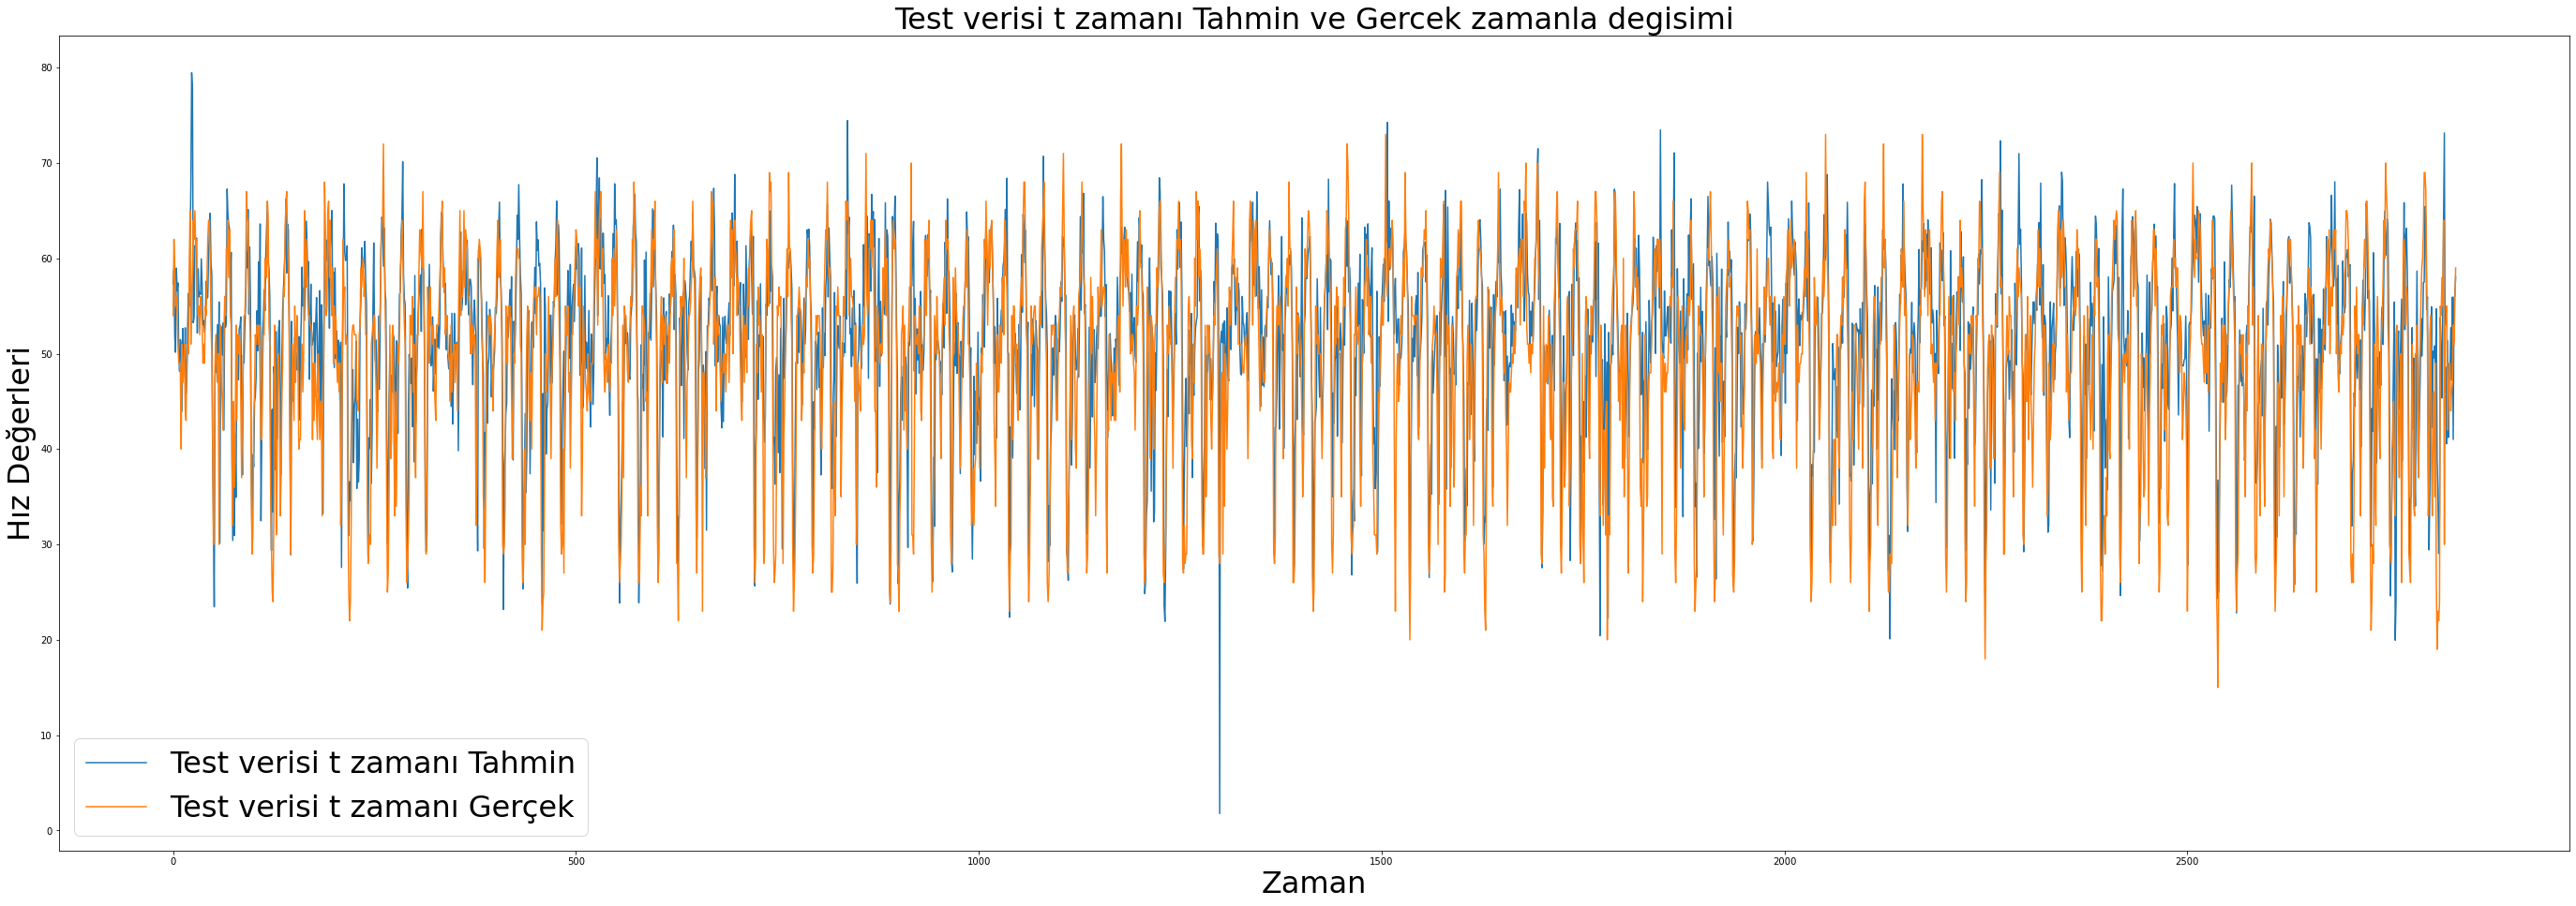

In [17]:
train_y1=train_y[:,0]
pred_train_y1=pred_train_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y1, label = "Train verisi t zamanı Tahmin")
plt.plot(train_y1, label = "Train verisi t zamanı Gerçek")
plt.title('Train verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

test_y1=test_y[:,0]
pred_test_y1=pred_test_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y1, label = "Test verisi t zamanı Tahmin")
plt.plot(test_y1, label = "Test verisi t zamanı Gerçek")
plt.title('Test verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y2=train_y[:,1]
pred_train_y2=pred_train_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y2, label = "Train verisi t+1 zamanı Tahmin")
plt.plot(train_y2, label = "Train verisi t+1 zamanı Gerçek")
plt.title('Train verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y2=test_y[:,1]
pred_test_y2=pred_test_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+1 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+1 zamanı Gerçek")
plt.title('Test verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y3=train_y[:,2]
pred_train_y3=pred_train_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y3, label = "Train verisi t+2 zamanı Tahmin")
plt.plot(train_y3, label = "Train verisi t+2 zamanı Gerçek")
plt.title('Train verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y3=test_y[:,2]
pred_test_y3=pred_test_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y3, label = "Test verisi t+2 zamanı Tahmin")
plt.plot(test_y3, label = "Test verisi t+2 zamanı Gerçek")
plt.title('Test verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')